#  Project Description

This capstone project was completed as a part of Google Advanced Data Analytical Certificate.

It is an opportunity to analyze a dataset and build predictive models that can provide insights to the Human Resources department of a fictional consulting firm. The HR department wants to improve employee satisfaction levels at the company. They ask to provide data-driven suggestions. They have the following question: what’s likely to make the employee leave the company?

The goals in this project are:
- to analyze the data
- to build a model that predicts whether or not an employee will leave the company
- to identify factors that contribute to their leaving.

A brief one-page summary of this project can be accessed here:

https://docs.google.com/presentation/d/1s5NajnG2Uyt-4lr9lFbpYWEKxv-Sd_iraJ4f5c1EK9w/edit?usp=sharing


# Step 1: Initial Data Exploration and Data Cleaning

### 1.1 Import statesments

In [1]:
# For data manipulation
import numpy as np
import pandas as pd
# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

### 1.2 Initial Data Exploration

In [2]:
# Load dataset into a dataframe
df0 = pd.read_csv('/kaggle/input/hr-analytics-and-job-prediction/HR_comma_sep.csv')
# Display first few rows of the dataframe
df0.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
# Gather basic information about the columns
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


### 1.3 Format the column names

In [4]:
# Rename columns as needed
df0 = df0.rename(columns={'Work_accident': 'work_accident',
'average_montly_hours': 'average_monthly_hours',
'time_spend_company': 'tenure',
'Department': 'department'})

### 1.4 Duplicates and missing values

In [5]:
# Check for missing values
df0.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

In [6]:
# Check for duplicates
df0.duplicated().sum()

3008

With several continuous variables across 10 columns, it seems very unlikely that these observations are legitimate.

In [7]:
# Drop duplicates and save resulting dataframe in a new variable as needed
df1 = df0.drop_duplicates(keep='first')

### 1.5 Examine the `tenure` column for outliers

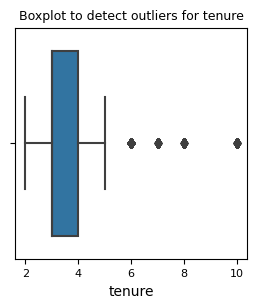

In [8]:
# Create a boxplot to visualize distribution of `tenure` and detect any outliers
plt.figure(figsize=(3,3))
plt.title('Boxplot to detect outliers for tenure', fontsize=9)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
sns.boxplot(x=df1['tenure'])
plt.show()

Determine the number of rows containing outliers

In [9]:
# Compute the 25th percentile value in `tenure`
percentile25 = df1['tenure'].quantile(0.25)
# Compute the 75th percentile value in `tenure`
percentile75 = df1['tenure'].quantile(0.75)
# Compute the interquartile range in `tenure`
iqr = percentile75 - percentile25
# Define the upper limit and lower limit for non-outlier values in `tenure`
upper_limit = percentile75 + 3 * iqr
lower_limit = percentile25 - 3 * iqr
print("Interquartile Range", iqr)
print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)
# Identify subset of data containing outliers in `tenure`
outliers = df1[(df1['tenure'] > upper_limit) | (df1['tenure'] < lower_limit)]
# Count how many rows in the data contain outliers in `tenure`
print("Number of rows in the data containing outliers in `tenure`:",len(outliers))

Interquartile Range 1.0
Lower limit: 0.0
Upper limit: 7.0
Number of rows in the data containing outliers in `tenure`: 188


# Step 2: Further Data Exploratory Analysis

### 2.1 Examine outcome variable

In [10]:
# Get numbers of people who left vs. stayed
print(df1['left'].value_counts())
# Get percentages of people who left vs. stayed
print(df1['left'].value_counts(normalize=True))

left
0    10000
1     1991
Name: count, dtype: int64
left
0    0.833959
1    0.166041
Name: proportion, dtype: float64


### 2.2 Visualize relationships between `average_monthly_hours` and `number_project`

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

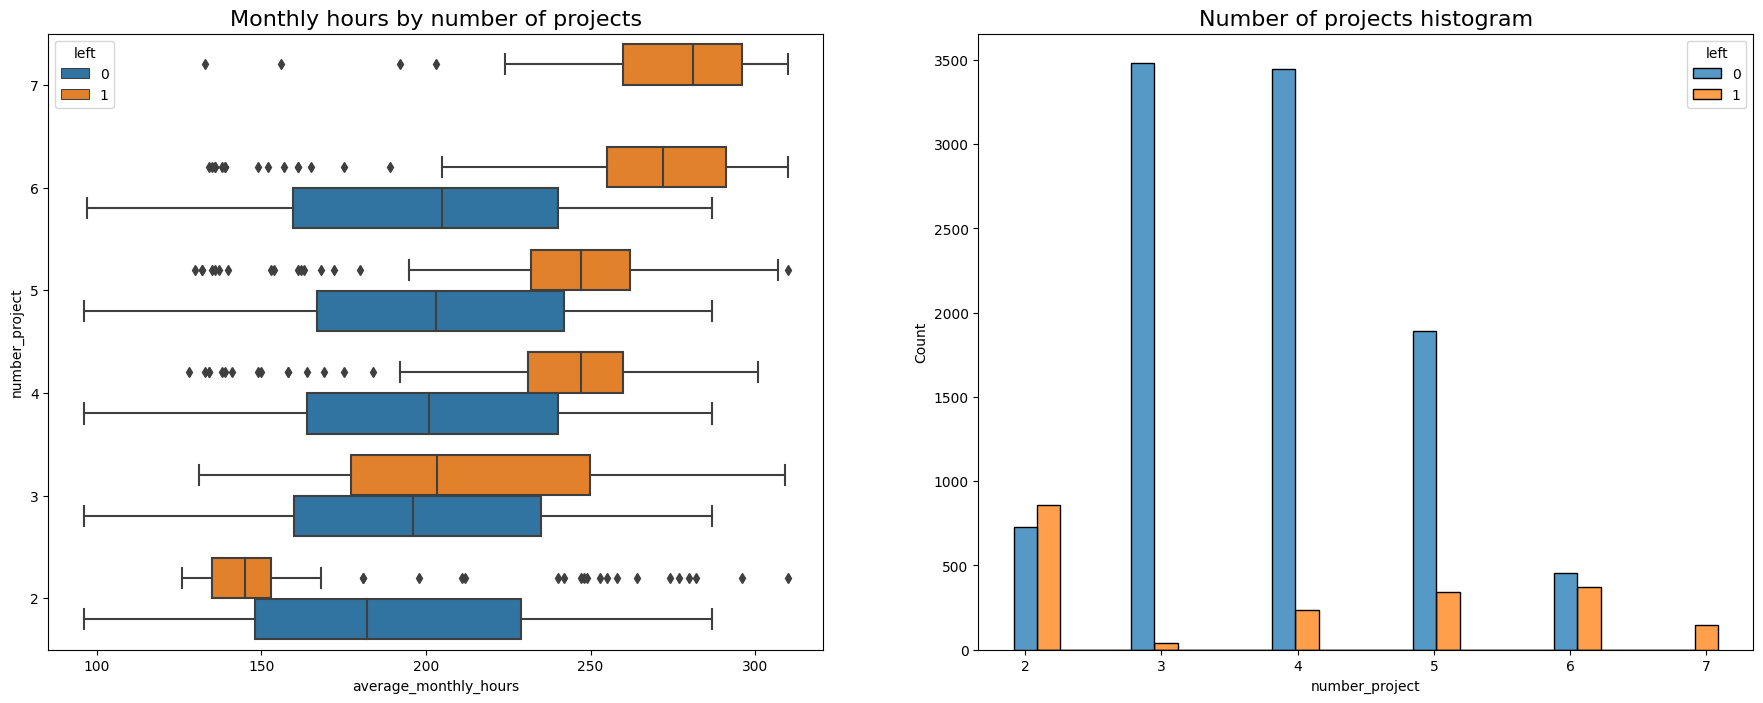

In [11]:
# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))
# Create boxplot showing `average_monthly_hours` distributions for `number_project`, 
# comparing employees who stayed versus those who left
sns.boxplot(data=df1, x='average_monthly_hours', y='number_project', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Monthly hours by number of projects', fontsize='16')
# Create histogram showing distribution of `number_project`, 
# comparing employees who stayed versus those who left
tenure_stay = df1[df1['left']==0]['number_project']
tenure_left = df1[df1['left']==1]['number_project']
sns.histplot(data=df1, x='number_project', hue='left', multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Number of projects histogram', fontsize='16')
# Display the plots
plt.show()


It's natural that people who work on more projects would also work longer hours. The mean hours of those who stayed and those who left increasing with number of projects worked. 

However, a few things stand out from this plot.

1. There are two groups of employees who left the company: (A) those who worked noticebly less than their peers with the same number of projects, and (B) those who worked much more. Of those in group A, it’s possible that they were fired. For those in group B, it’s reasonable to infer that they probably quit. The folks in group B might have been the largest contributors to their projects.
2. Everyone with 7 projects left the company, and the interquartile ranges of this group and those who left with six projects was over 250 hours/month — much more than any other group. And almost a half of those with 6 projects also left the company.
3. The optimal number of projects for employees to work on seems to be 3–4. The ratio of left/stayed is very small for these cohorts.
4. If you assume a work week of 40 hours and two weeks of vacation per year, then the average number of working hours per month of employees working Monday–Friday is ~170 hours per month. This means that, aside from the employees who were likely fired, every group — including those who didn’t leave the company — worked considerably more hours. It seems that employees are overworked.


### 2.3 Examine `average_monthly_hours` versus `satisfaction_level`

Text(0.5, 1.0, 'Monthly hours by last evaluation score')

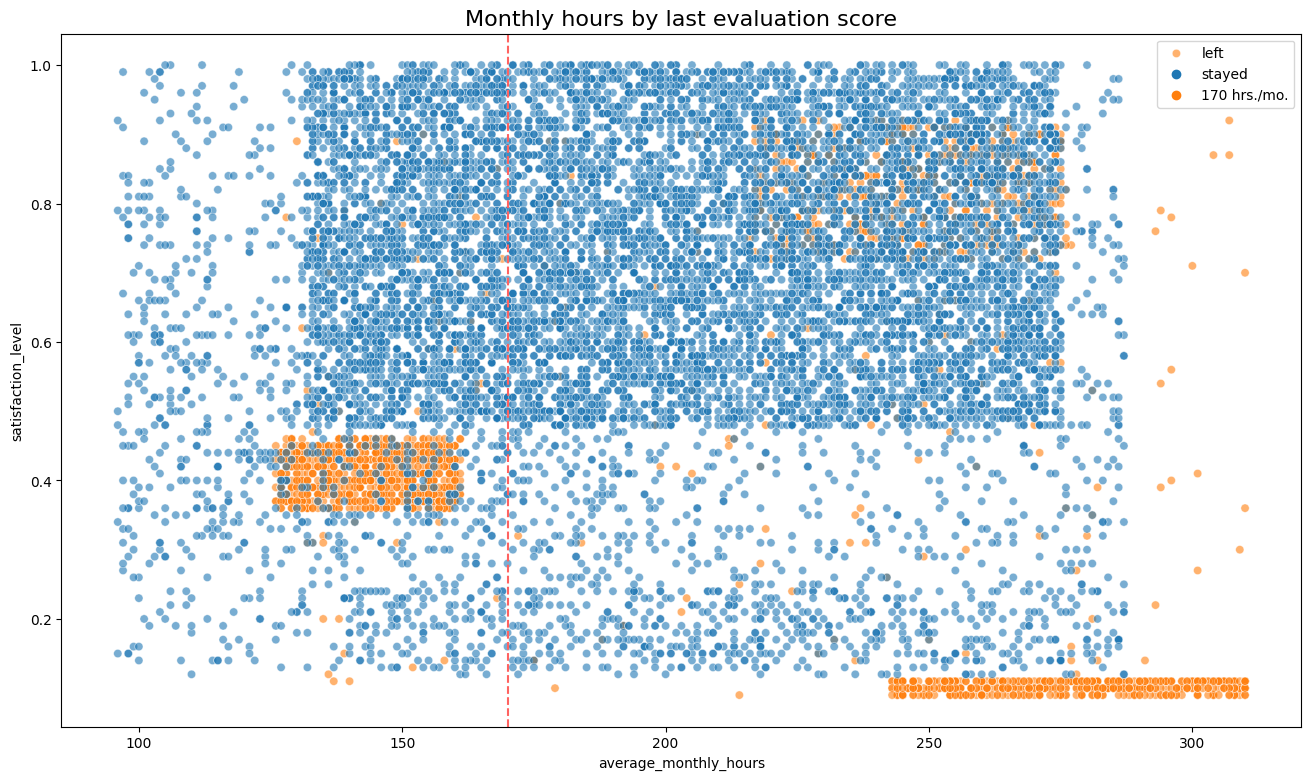

In [12]:
# Create scatterplot of `average_monthly_hours` versus `satisfaction_level`,
# comparing employees who stayed versus those who left
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df1, x='average_monthly_hours', y='satisfaction_level', hue='left', alpha=0.6)
plt.axvline(x=170, color='#ff6361', label='170 hrs./mo.', ls='--')
plt.legend(labels=['left', 'stayed', '170 hrs./mo.'])
plt.title('Monthly hours by last evaluation score', fontsize='16')

Note the strange shape of the distributions. This is indicative of synthetic data.

### 2.4 Examine `satisfaction_levels` versus `tenure`

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

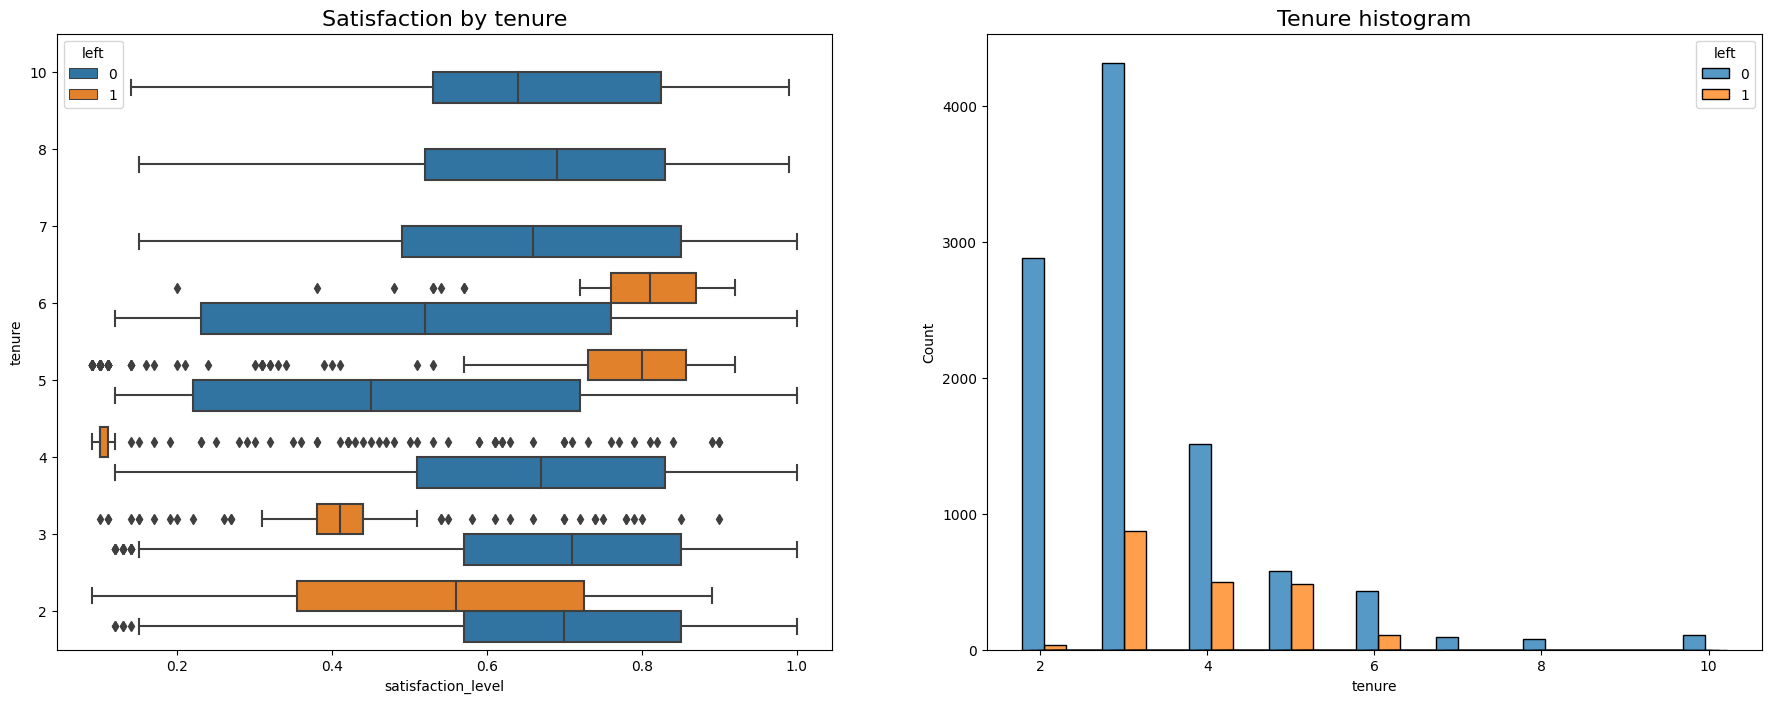

In [13]:
# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))
# Create boxplot showing distributions of `satisfaction_level` by tenure,
# comparing employees who stayed versus those who left
sns.boxplot(data=df1, x='satisfaction_level', y='tenure', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction by tenure', fontsize='16')
# Create histogram showing distribution of `tenure`, comparing employees who stayed versus those who left
tenure_stay = df1[df1['left']==0]['tenure']
tenure_left = df1[df1['left']==1]['tenure']
sns.histplot(data=df1, x='tenure', hue='left', multiple='dodge', shrink=6, ax=ax[1])
ax[1].set_title('Tenure histogram', fontsize='16')
plt.show();

A few observations we can make from this plot:
- Employees who left fall into two general categories: dissatisfied employees with shorter tenures and very satisfied employees with medium-length tenures.
- Four-year employees who left seem to have an unusually low satisfaction level.
- The longest-tenured employees didn’t leave.

### 2.5 Calculate mean and median satisfaction scores for those who left and those who stayed

In [14]:
# Calculate mean and median satisfaction scores of employees who left and those who stayed
df1.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])

/tmp/ipykernel_19/1074052523.py:2: FutureWarning: The provided callable <function mean at 0x7d40040fbd90> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df1.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])
/tmp/ipykernel_19/1074052523.py:2: FutureWarning: The provided callable <function median at 0x7d3fec24b490> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df1.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])


,mean,median
left,,
0,0.667365,0.69
1,0.440271,0.41


### 2.6 Calculate mean and median `last_evaluation` scores for those who left and those who stayed

In [15]:
# Calculate mean and median last_evaluation scores of employees who left and those who stayed
df1.groupby(['left'])['last_evaluation'].agg([np.mean,np.median])

/tmp/ipykernel_19/3131002729.py:2: FutureWarning: The provided callable <function mean at 0x7d40040fbd90> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df1.groupby(['left'])['last_evaluation'].agg([np.mean,np.median])
/tmp/ipykernel_19/3131002729.py:2: FutureWarning: The provided callable <function median at 0x7d3fec24b490> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df1.groupby(['left'])['last_evaluation'].agg([np.mean,np.median])


,mean,median
left,,
0,0.715667,0.71
1,0.721783,0.79


### 2.7 Examine whether employees who worked very long hours were promoted

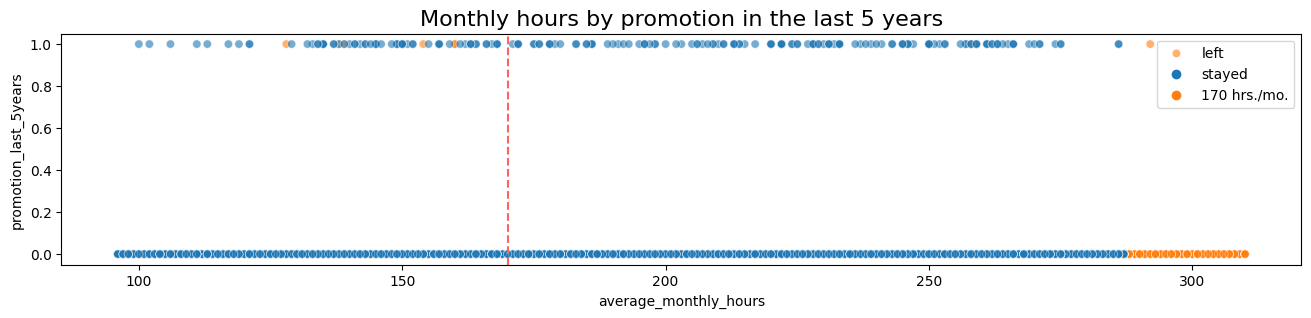

In [16]:
# Create plot to examine relationship between `average_monthly_hours` and `promotion_last_5years`
plt.figure(figsize=(16, 3))
sns.scatterplot(data=df1, x='average_monthly_hours', y='promotion_last_5years', hue='left', alpha=0.6)
plt.axvline(x=170, color='#ff6361', ls='--')
plt.legend(labels=['left', 'stayed', '170 hrs./mo.'])
plt.title('Monthly hours by promotion in the last 5 years', fontsize='16');

- Very few employees who were promoted in the last five years left.
- Very few employees who worked the most hours were promoted. 
- The employees who left were working the longest hours.

### 2.8 Check for strong correlations between variables

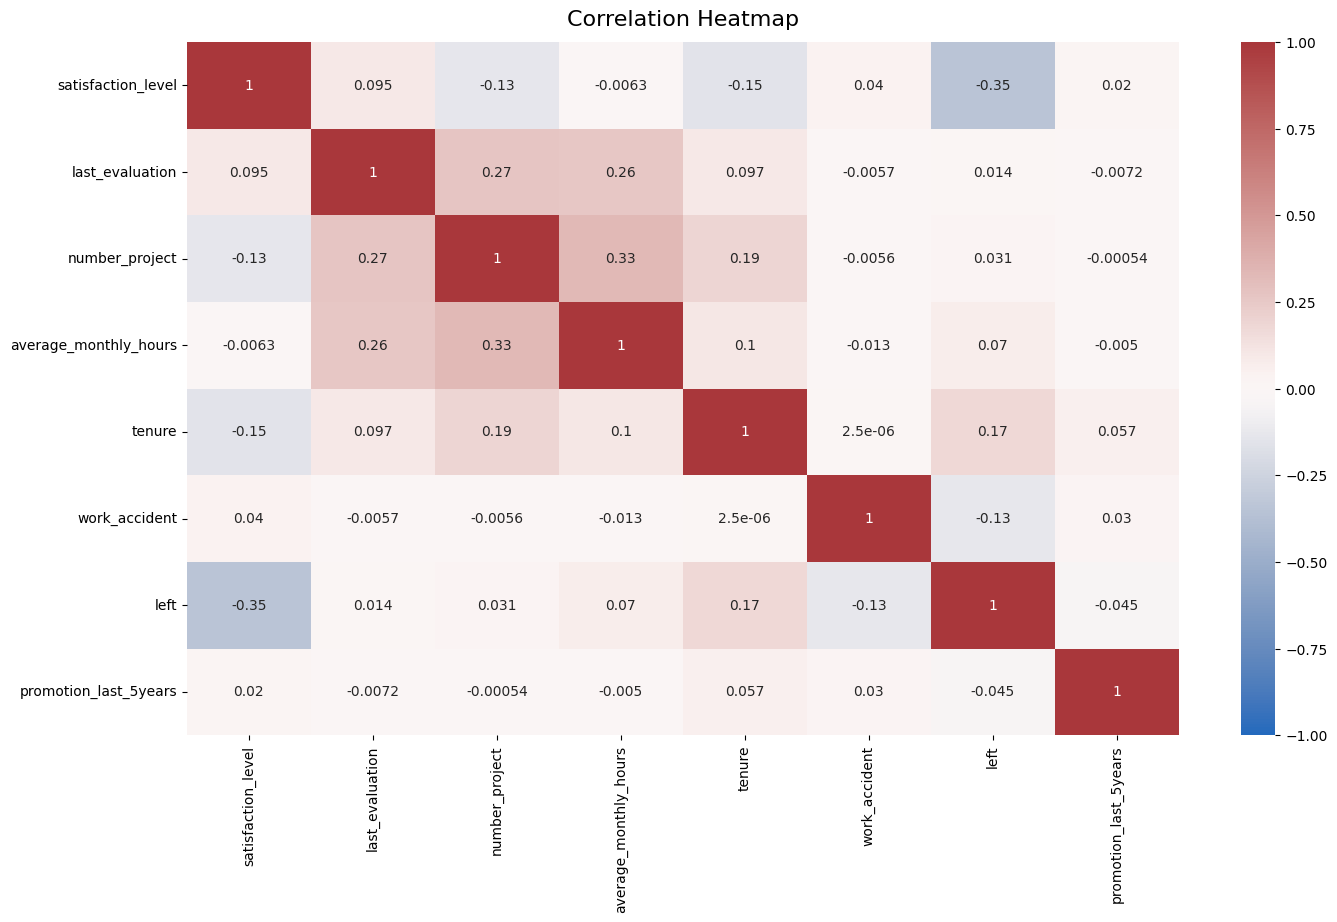

In [17]:
# Drop `department` and `salary` columns
df2 = df1.drop(['department','salary'], axis=1)
# Plot a correlation heatmap
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(df2.corr(), vmin=-1, vmax=1, annot=True, 
                      cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':16}, pad=12);


The correlation heatmap confirms that the number of projects, monthly hours, and evaluation scores
all have some positive correlation with each other, and whether an employee leaves is negatively
correlated with their satisfaction level.

### 2.9 Insights from EDA

Employees are leaving the company as a result of poor management. Leaving is tied to longer working hours, many projects, and generally lower satisfaction levels. There’s a sizeable group of employees at this company who might be burned out. It also appears that if an employee has spent more than six years at the company, they tend not to leave.


# Step 3: Logistic Regression Modeling

The goal is to predict whether an employee leaves the company, which is a binary categorical outcome
variable. In ither words this task involves classification. In this case we could either build a Logistic Regression model, or a Tree-based Machine Learning model.

### 3.1 Preparing the data for Regression Modeling

Logistic Regression model assumptions:
- Outcome variable is categorical 
- Observations are independent of each other 
- No severe multicollinearity among X variables 
- No extreme outliers
- Linear relationship between each X variable and the logit of the outcome variable 
- Sufficiently large sample size

The outliers in tenure column will be handled with in the following code. Apart from that, all the assumptions are met. 

In [18]:
# Copy the dataframe
df_enc = df1.copy()
# Encode the `salary` column as an ordinal numeric category
df_enc['salary'] = (
df_enc['salary'].astype('category')
.cat.set_categories(['low', 'medium', 'high'])
.cat.codes
)
# Drop the `department` column
df_enc = df_enc.drop(['department'], axis=1)
# Display the new dataframe
df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary
0,0.38,0.53,2,157,3,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1
2,0.11,0.88,7,272,4,0,1,0,1
3,0.72,0.87,5,223,5,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0


In [19]:
# Select rows without outliers in `tenure` and save resulting dataframe in a new variable
df_logreg = df_enc[(df_enc['tenure'] >= lower_limit) & (df_enc['tenure'] <= upper_limit)]
# Display first few rows of new dataframe
df_logreg.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary
0,0.38,0.53,2,157,3,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1
2,0.11,0.88,7,272,4,0,1,0,1
3,0.72,0.87,5,223,5,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0


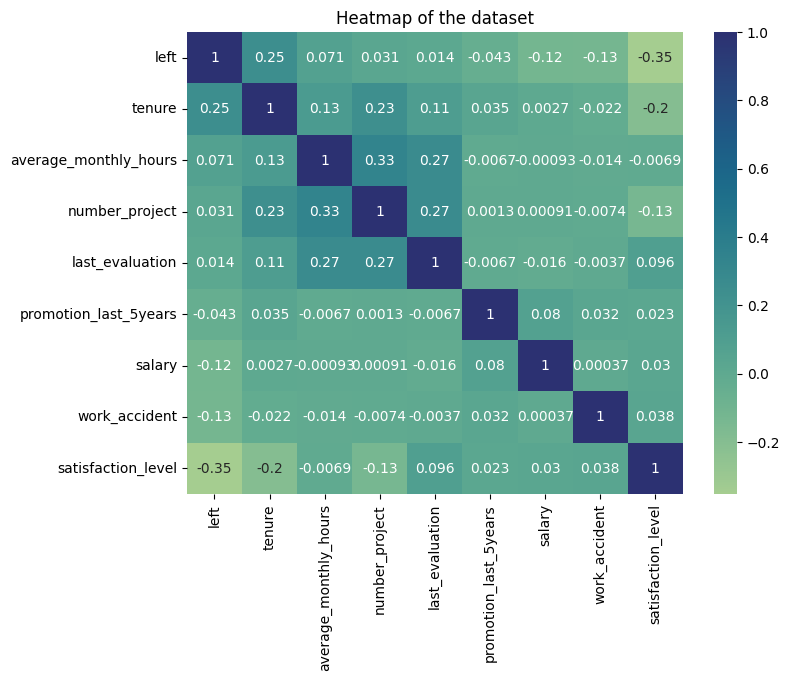

In [20]:
# Create a heatmap to visualize how correlated variables are
plt.figure(figsize=(8, 6))
sns.heatmap(df_logreg[['left', 'tenure', 'average_monthly_hours', 'number_project', 'last_evaluation', 'promotion_last_5years', 
                    'salary', 'work_accident', 'satisfaction_level']].corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

### 3.2 Fitting the data

In [21]:
# Isolate the outcome variable
y = df_logreg['left']
# Display first few rows of the outcome variable
y.head()

0    1
1    1
2    1
3    1
4    1
Name: left, dtype: int64

In [22]:
# Select the features to use in the model
X = df_logreg.drop('left', axis=1)
# Display the first few rows of the selected features
X.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary
0,0.38,0.53,2,157,3,0,0,0
1,0.80,0.86,5,262,6,0,0,1
2,0.11,0.88,7,272,4,0,0,1
3,0.72,0.87,5,223,5,0,0,0
4,0.37,0.52,2,159,3,0,0,0


In [23]:
# Split the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

In [24]:
# Construct a logistic regression model and fit it to the training dataset
log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train,y_train)

### 3.3 Vusializing the effect of the two most powerful predictors

<Axes: xlabel='satisfaction_level', ylabel='left'>

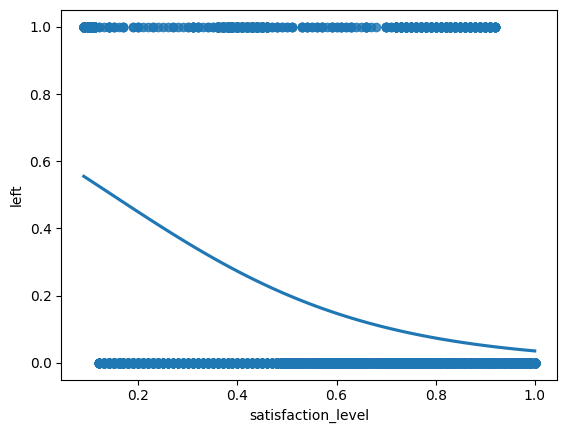

In [25]:
sns.regplot(x="satisfaction_level", y="left", data=df_logreg, logistic=True, ci=None)

<Axes: xlabel='tenure', ylabel='left'>

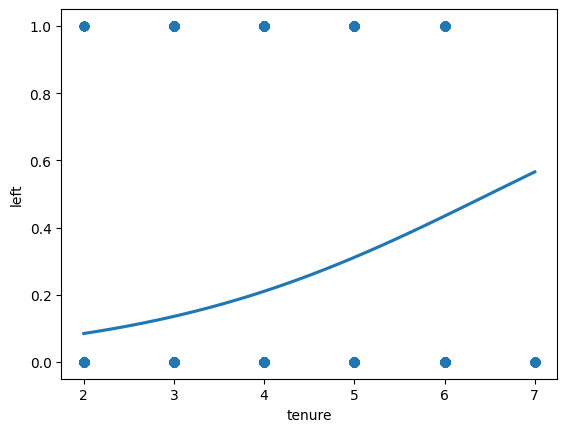

In [26]:
sns.regplot(x="tenure", y="left", data=df_logreg, logistic=True, ci=None)

### 3.4 Evaluating Logistic Regression

In [27]:
# Use the logistic regression model to get predictions on the test set
y_pred = log_clf.predict(X_test)

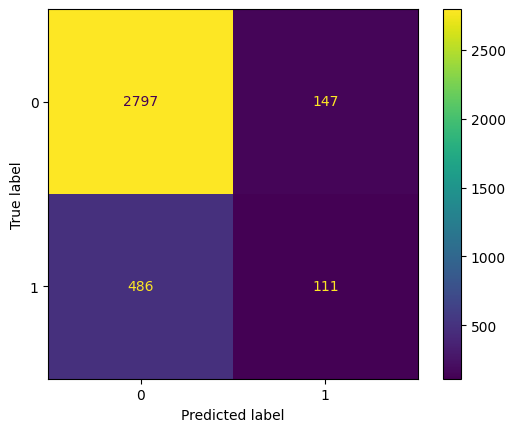

In [28]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)
# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm,
display_labels=log_clf.classes_)
# Plot confusion matrix
log_disp.plot(values_format='')
# Display plot
plt.show()

The upper-left quadrant displays the number of true negatives. The bottom-right quadrant displays the number of true positives. Those are accurately predicted observations, therefore, the higher portion of observations falls into those two quadrants, the better.

The opposite is true for upper-right and bottom-left quadrants, because those are inaccurately predicted observations.

A perfect model would yield all true negatives and true positives, and no false negatives or false
positives.

In [29]:
print("Accuracy:", "%.2f" % accuracy_score(y_test, y_pred))
print("Precision:", "%.2f" % precision_score(y_test, y_pred))
print("Recall:", "%.2f" % recall_score(y_test, y_pred))
print("F1 Score:", "%.2f" % f1_score(y_test, y_pred))

Accuracy: 0.82
Precision: 0.43
Recall: 0.19
F1 Score: 0.26


According to evaluation metrics above  the logistic regression model achieved a reasonably high accuracy of 82%, but a rather low precision of 43%, recall of 19%, and f1-score of 26%. It means that when it comes to predicting employees who leave, the predictive power of the model is quite low. 

Therefore, it makes perfect sense to implement a Decision Tree.

# Step 4: Decision Tree Modeling

### 4.1 Preparing the data

In [30]:
# Isolate the outcome variable
y = df_enc['left']
# Display the first few rows of `y`
y.head()

0    1
1    1
2    1
3    1
4    1
Name: left, dtype: int64

In [31]:
# Select the features
X = df_enc.drop('left', axis=1)
# Display the first few rows of `X`
X.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary
0,0.38,0.53,2,157,3,0,0,0
1,0.80,0.86,5,262,6,0,0,1
2,0.11,0.88,7,272,4,0,0,1
3,0.72,0.87,5,223,5,0,0,0
4,0.37,0.52,2,159,3,0,0,0


In [32]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=24)

### 4.2 Constructing the model

We'll construct a decision tree model and set up cross-validated grid-search to search for the best model parameters.

In [33]:
# Instantiate model
tree = DecisionTreeClassifier(random_state=0)
# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8],
'min_samples_leaf': [1, 2, 5],
'min_samples_split': [2, 4, 6]
}
# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}
# Instantiate GridSearch
tree0 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')


Fit the decision tree model to the training data.

In [34]:
%%time
tree0.fit(X_train, y_train)

CPU times: user 3.32 s, sys: 4.2 ms, total: 3.33 s
Wall time: 3.33 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8], 'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'f1', 'roc_auc', 'accuracy', 'precision', 'recall'})

In [35]:
# Check best parameters
tree0.best_params_

{'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}

### 4.3 Evaluating the model

In [36]:
# Check best AUC score on CV
tree0.best_score_

0.9686178125733109

This is a strong AUC score, which shows that this model can predict employees who will leave very well.

In [37]:
# Write a function that will help extract all the scores from the grid search
def make_results(model_name:str, model_object, metric:str):
    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
    'precision': 'mean_test_precision',
    'recall': 'mean_test_recall',
    'f1': 'mean_test_f1',
    'accuracy': 'mean_test_accuracy'
    }
    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)
    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]
    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
    'precision': [precision],
    'recall': [recall],
    'F1': [f1],
    'accuracy': [accuracy],
    'auc': [auc]
    })
    return table

In [38]:
# Get all CV scores
tree0_cv_results = make_results('decision tree cv', tree0, 'auc')
tree0_cv_results

,model,precision,recall,F1,accuracy,auc
0,decision tree cv,0.928947,0.909612,0.919136,0.97343,0.968618


All of these scores from the decision tree model are strong indicators of good model performance.

### 4.4 Visualizing results

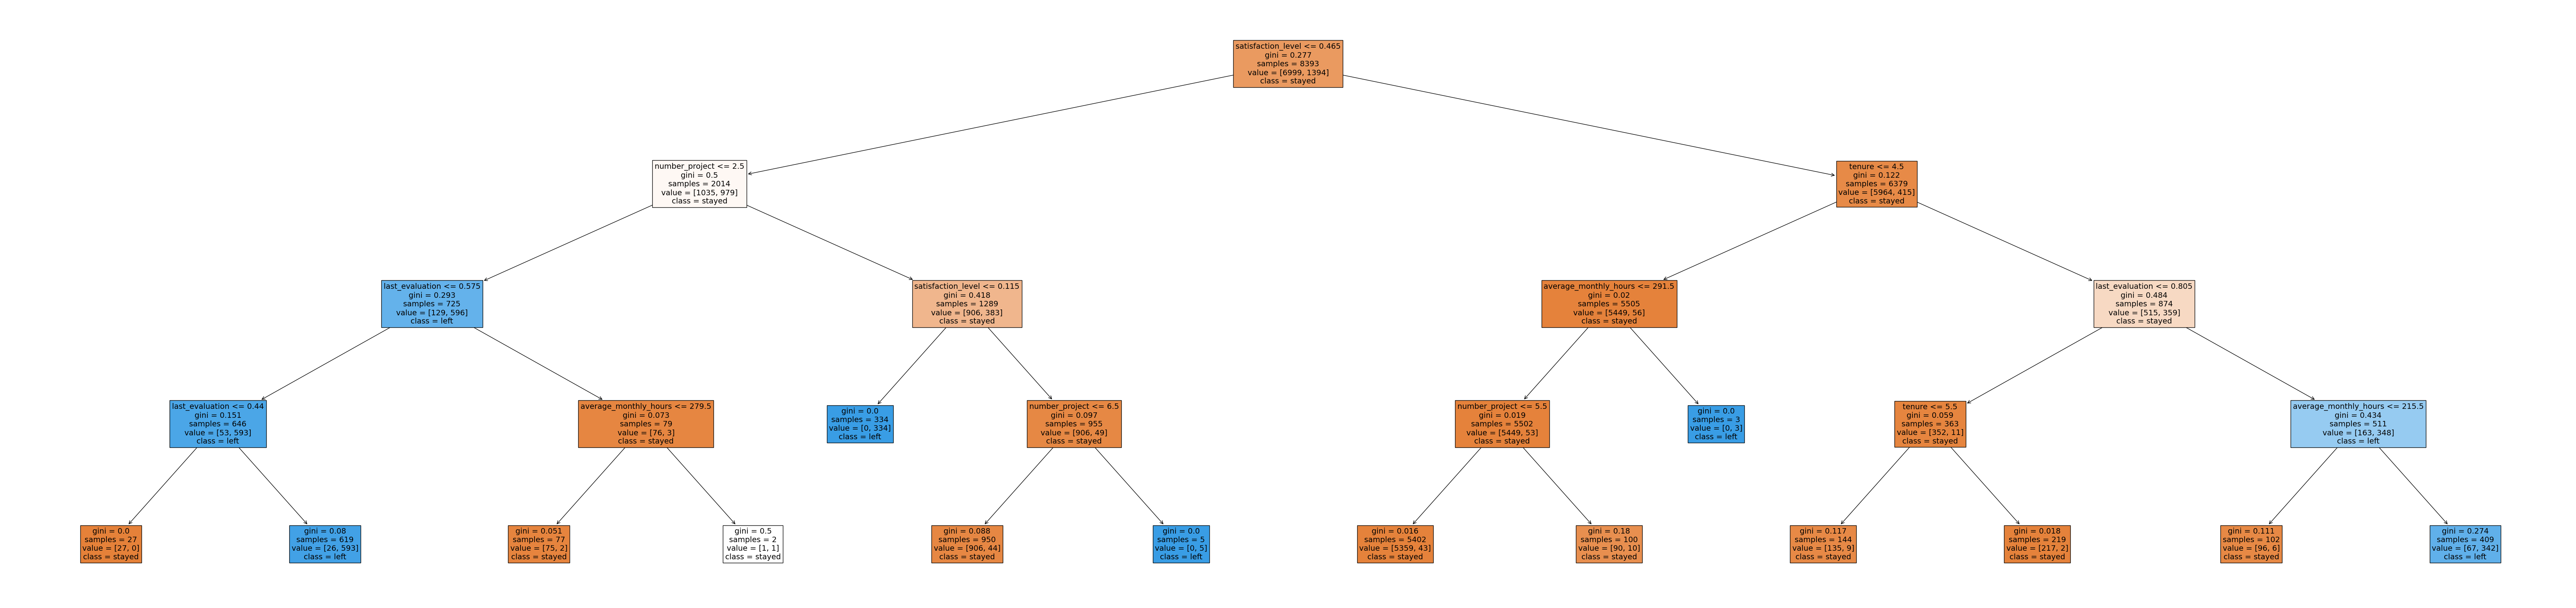

In [39]:
# Plot the tree
plt.figure(figsize=(85,20))
plot_tree(tree0.best_estimator_, fontsize=14, feature_names=X.columns,
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

In [40]:
# Get feature importance from the decision tree
tree0_importances = pd.DataFrame(tree0.best_estimator_.feature_importances_,
                                 columns=['gini_importance'],index=X.columns
                                )
tree0_importances = tree0_importances.sort_values(by='gini_importance', ascending=False)
# Only extract the features with importances > 0
tree0_importances = tree0_importances[tree0_importances['gini_importance'] != 0]
tree0_importances

,gini_importance
satisfaction_level,0.509665
last_evaluation,0.173426
number_project,0.137425
tenure,0.125107
average_monthly_hours,0.054377


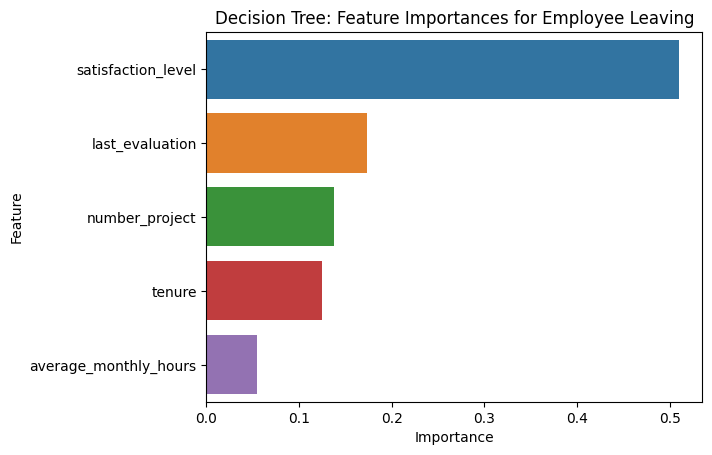

In [41]:
# Create a barplot to visualize the decision tree feature importances
sns.barplot(data=tree0_importances, x="gini_importance", y=tree0_importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

# Step 5: Recommendations

The models and the feature importances extracted from the models confirm that employees at the company are overworked.

To retain employees, the following recommendations could be presented to the stakeholders:
- Cap the number of projects that employees can work on.
- Either reward employees for working longer hours, or don’t require them to do so.
- If employees aren’t familiar with the company’s overtime pay policies, inform them. If the expectations around workload and time off aren’t explicit, make them clear.
- Hold company-wide and within-team discussions to understand and address the company work culture, across the board and in specific contexts.
- High evaluation scores should not be reserved for employees who work 200+ hours per month.